In [1]:
from pandas import read_csv
from pandas import set_option

from matplotlib import pyplot

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd

In [2]:
##### load dataset

filenameTrain = 'train.csv'
filenameTest = 'test.csv' #note: this not my testing, but is Kaggle submission
train_data = read_csv(filenameTrain)
toPredict_data = read_csv(filenameTest)

In [3]:
##### test and look at 
# train_data.shape
# toPredict_data.shape

train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
##### need to know if NAs and stuff
train_data.describe()

####### results
# age has some missing according to count
# survived is binay
# PassengerId is not predictive
# some Fare shows 0; they got on free? or this wrong?
# Pclass looks ordinal, others continuous

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


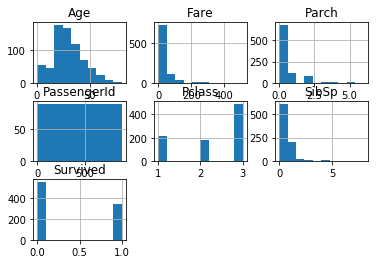

In [5]:
train_data.hist()
pyplot.show()

In [6]:
set_option('display.width', 100)
set_option('precision', 3)
correlations = train_data.corr(method='pearson')
print(correlations)

             PassengerId  Survived  Pclass    Age  SibSp  Parch   Fare
PassengerId        1.000    -0.005  -0.035  0.037 -0.058 -0.002  0.013
Survived          -0.005     1.000  -0.338 -0.077 -0.035  0.082  0.257
Pclass            -0.035    -0.338   1.000 -0.369  0.083  0.018 -0.549
Age                0.037    -0.077  -0.369  1.000 -0.308 -0.189  0.096
SibSp             -0.058    -0.035   0.083 -0.308  1.000  0.415  0.160
Parch             -0.002     0.082   0.018 -0.189  0.415  1.000  0.216
Fare               0.013     0.257  -0.549  0.096  0.160  0.216  1.000


In [7]:
##### curious how many Fare are zero, may need to impute
class_counts = train_data.groupby('Fare').size()
print(class_counts) # 15 out of 891, not bad

Fare
0.000      15
4.013       1
5.000       1
6.237       1
6.438       1
6.450       1
6.496       2
6.750       2
6.858       1
6.950       1
6.975       2
7.046       1
7.050       7
7.054       2
7.125       4
7.142       1
7.225      12
7.229      15
7.250      13
7.312       1
7.496       3
7.521       1
7.550       4
7.629       1
7.650       4
7.725       1
7.729       1
7.733       4
7.737       2
7.742       1
           ..
80.000      2
81.858      1
82.171      2
83.158      3
83.475      2
86.500      3
89.104      2
90.000      4
91.079      2
93.500      2
106.425     2
108.900     2
110.883     4
113.275     3
120.000     4
133.650     2
134.500     2
135.633     3
146.521     2
151.550     4
153.463     3
164.867     2
211.338     3
211.500     1
221.779     1
227.525     4
247.521     2
262.375     2
263.000     4
512.329     3
Length: 248, dtype: int64


In [8]:
#clean up-drop columns categorical, convert gender to numerical
train_data = train_data.drop(columns=['PassengerId','Name','Ticket','Cabin','Embarked'], axis=1)

#just realized,need to do all this to testing data also...

In [9]:
train_data.head(4)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.250
1,1,1,female,38.0,1,0,71.283
2,1,3,female,26.0,0,0,7.925
3,1,1,female,35.0,1,0,53.100


In [10]:
# repeat for test data to submit to competition
# note we havn't made our normal train test split yet 
toPredict_data = toPredict_data.drop(columns=['PassengerId','Name','Ticket','Cabin','Embarked'], axis=1)
# Whoops... need to keep the PassengerId... i think...? or can i add it back in later... <shug>

In [11]:
mapping = {'male': 0, 'female': 1}
train_data = train_data.replace({'Sex': mapping})

# this was a bit painful and lots of Googling, not sure if need to cast to boolean, maybe

In [12]:
mapping = {'male': 0, 'female': 1}
toPredict_data = toPredict_data.replace({'Sex': mapping})


In [13]:
toPredict_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,0,34.5,0,0,7.829
1,3,1,47.0,1,0,7.000
2,2,0,62.0,0,0,9.688
3,3,0,27.0,0,0,8.662
4,3,1,22.0,1,1,12.287


In [14]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.250
1,1,1,1,38.0,1,0,71.283
2,1,3,1,26.0,0,0,7.925
3,1,1,1,35.0,1,0,53.100
4,0,3,0,35.0,0,0,8.050


In [15]:
##### i'll need to impute to toPredict_data also because
##### I noticed missing values in Age i forgot about when trying to array it 
##### fixing it here

train_data["Age"].fillna(train_data["Age"].mean(), inplace=True)
# inplace=True means that the changes are saved to the df right away

In [16]:
##### need to remember to prep the submitting test data as we go
toPredict_data["Age"].fillna(toPredict_data["Age"].mean(), inplace=True)

In [17]:
array = train_data.values # not the labels 
X = array[:,1:8]
Y = array[:,0] 

LR: 0.794632 (0.031257)
LDA: 0.795743 (0.041936)
KNN: 0.712747 (0.043048)
CART: 0.790112 (0.036996)
NB: 0.785655 (0.020737)
SVM: 0.693683 (0.051387)


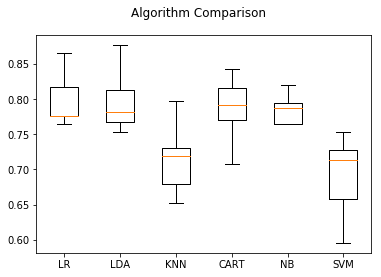

In [18]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = KFold(n_splits=10, random_state=7)
	cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [19]:
# create pipeline
estimators = []

estimators.append(('standardize', StandardScaler()))
estimators.append(('LR', LogisticRegression()))

model = Pipeline(estimators)

# evaluate pipeline
kfold = KFold(n_splits=10, random_state=7)

results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.7867665418227217


In [20]:
## fix the one missing Fare value
toPredict_data["Fare"].fillna(toPredict_data["Fare"].mean(), inplace=True)

In [21]:
## might as well replace the zero fare values with mean also while i'm at it
Fare_mean = toPredict_data["Fare"].mean(skipna=True)
toPredict_data["Fare"]=toPredict_data.Fare.mask(toPredict_data.Fare == 0,Fare_mean)

In [22]:
# Rescale toPredictData - be  better to build the rescaled data on combined set (I think)
arrayT = toPredict_data.values #not the labels ?
YT = arrayT[:,0:6] 

In [23]:
# 1. Rescale the test data
# 2. Fit the model from original X and Y built
# 3. Apply this model, predicting on the YT (the 'test.csv' file already prepped)
StandardScaler(YT)
model.fit(X, Y)
predicted = model.predict(YT).astype(int)

In [24]:
# re-get the test file for the passengerIds (a bit hackish), add predictions column to it using Pandas
filenameTest = 'test.csv'
toPredict_data2 = read_csv(filenameTest)
toPredict_data2['Survived'] = pd.Series(data=predicted)

In [25]:
# pulling only 2 columns to conform to submission standard to upload, 
submission = pd.DataFrame({'PassengerId': toPredict_data2.loc[:, 'PassengerId'],
                           'Survived': toPredict_data2.loc[:, 'Survived']})

In [26]:
# dump prdictions to file - but NOT with the row index - using PassengerID as index
submission.to_csv("submission.csv", index = False) 